<a href="https://colab.research.google.com/github/abhizc/EIP4/blob/master/Assignment_5/final_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library

In [0]:
%tensorflow_version 1.x
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, Input, Flatten, Dropout, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import pandas as pd
import os
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils.vis_utils import plot_model


from functools import partial
from pathlib import Path 
from tqdm import tqdm

from keras.optimizers import SGD


## Data

In [47]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
%ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])        
        if self.augmentation is not None:
            images = self.augmentation.flow(images, shuffle=False).next()
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False)
train_gen = PersonDataGenerator(
    train_df, 
    batch_size=32, 
    augmentation=ImageDataGenerator(
        horizontal_flip=True,
        #zoom_range=0.5,
        #width_shift_range=0.5, 
    )
)



images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}


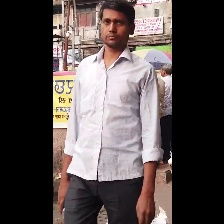

In [65]:
cv2_imshow(train_gen[4][0][0])

## Regularization

In [0]:
def lr_schedule(epoch):
  lr = epoch/5000
  return lr
          



## Model

In [0]:
batch_size = 128
epochs = 50
num_classes = 10
n = 3


depth = n * 6 + 2

model_type = 'ResNet%d' % (depth)


In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):

    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    neck = Flatten()(x)
    neck = Dense(512, activation="relu")(neck)


    def build_tower(in_layer):
        neck = Dropout(0.2)(in_layer)
        neck = Dense(128, activation="relu")(neck)
        neck = Dropout(0.3)(in_layer)
        neck = Dense(128, activation="relu")(neck)
        return neck


    def build_head(name, in_layer):
       return Dense(
            num_units[name], activation="softmax", name=f"{name}_output"
       )(in_layer)

    # heads
    gender = build_head("gender", build_tower(neck))
    image_quality = build_head("image_quality", build_tower(neck))
    age = build_head("age", build_tower(neck))
    weight = build_head("weight", build_tower(neck))
    bag = build_head("bag", build_tower(neck))
    footwear = build_head("footwear", build_tower(neck))
    emotion = build_head("emotion", build_tower(neck))
    pose = build_head("pose", build_tower(neck))


    model = Model(
        inputs=inputs, 
        outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
    )
    return model

In [83]:
model = resnet_v1(input_shape=(224, 224, 3), depth=depth)

losses = {
 	"gender_output": "binary_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"age_output": "categorical_crossentropy",
	"weight_output": "mean_squared_error",
  "bag_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "emotion_output": "mean_squared_error"
 }
#loss_weights = {"gender_output": 1.0, "image_quality_output": 0, "age_output": 0, "weight_output":0, "bag_output":0, "pose_output":0, "footwear_output": 0, "emotion_output": 0 }
opt = SGD(lr=0.0001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss=losses, 
    #loss_weights=loss_weights, 
    metrics=["accuracy"]
)


print(model_type)
#model.summary()


ResNet20


In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())


In [0]:
# Prepare model model saving directory.
save_dir = ("gdrive/My Drive/Model")
model_name = "model.h5"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,verbose=1)

clr = CyclicLR(base_lr=0.00001, max_lr=0.001,step_size=2000., mode='triangular2')

callbacks = [clr]

In [0]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [87]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
  2/360 [..............................] - ETA: 21:48 - loss: 17.0314 - gender_output_loss: 1.5038 - image_quality_output_loss: 2.0940 - age_output_loss: 4.0469 - weight_output_loss: 0.1557 - bag_output_loss: 3.4876 - footwear_output_loss: 1.9011 - pose_output_loss: 3.4341 - emotion_output_loss: 0.2509 - gender_output_acc: 0.4688 - image_quality_output_acc: 0.3281 - age_output_acc: 0.1875 - weight_output_acc: 0.6719 - bag_output_acc: 0.2969 - footwear_output_acc: 0.2188 - pose_output_acc: 0.2500 - emotion_output_acc: 0.2812

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.555352). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


360/360 [==============================] - 105s 291ms/step - loss: 7.2205 - gender_output_loss: 0.7582 - image_quality_output_loss: 1.1213 - age_output_loss: 1.6499 - weight_output_loss: 0.1493 - bag_output_loss: 1.0586 - footwear_output_loss: 1.0840 - pose_output_loss: 1.0973 - emotion_output_loss: 0.1446 - gender_output_acc: 0.5487 - image_quality_output_acc: 0.4942 - age_output_acc: 0.3365 - weight_output_acc: 0.6264 - bag_output_acc: 0.5076 - footwear_output_acc: 0.4882 - pose_output_acc: 0.5636 - emotion_output_acc: 0.6220 - val_loss: 6.3658 - val_gender_output_loss: 0.6794 - val_image_quality_output_loss: 0.9505 - val_age_output_loss: 1.4365 - val_weight_output_loss: 0.1379 - val_bag_output_loss: 0.9749 - val_footwear_output_loss: 0.9595 - val_pose_output_loss: 0.9535 - val_emotion_output_loss: 0.1163 - val_gender_output_acc: 0.5809 - val_image_quality_output_acc: 0.5774 - val_age_output_acc: 0.4048 - val_weight_output_acc: 0.6260 - val_bag_output_acc: 0.4350 - val_footwear_outpu

In [88]:
def evaluate_model(model):
    results = model.evaluate_generator(valid_gen, verbose=1)
    accuracies = {}
    losses = {}
    for k, v in zip(model.metrics_names, results):
        if k.endswith('acc'):
            accuracies[k] = round(v * 100, 4) 
        else:
            losses[k] = v
    return accuracies

evaluate_model(model)

63/63 [==============================] - 5s 86ms/step


{'age_output_acc': 41.6171,
 'bag_output_acc': 60.3175,
 'emotion_output_acc': 72.4702,
 'footwear_output_acc': 65.6746,
 'gender_output_acc': 79.0675,
 'image_quality_output_acc': 58.9286,
 'pose_output_acc': 74.3056,
 'weight_output_acc': 63.1944}